In [1]:
pip install darts

  Attempting uninstall: statsforecast
    Found existing installation: statsforecast 0.6.0
    Uninstalling statsforecast-0.6.0:
      Successfully uninstalled statsforecast-0.6.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install statsforecast==0.6.0


  Using cached statsforecast-0.6.0-py3-none-any.whl.metadata (12 kB)
Using cached statsforecast-0.6.0-py3-none-any.whl (44 kB)
  Attempting uninstall: statsforecast
    Found existing installation: statsforecast 1.7.8
    Uninstalling statsforecast-1.7.8:
      Successfully uninstalled statsforecast-1.7.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
darts 0.30.0 requires statsforecast>=1.4, but you have statsforecast 0.6.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
conda install -c conda-forge lightgbm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 24.9.1

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.9.1



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
import fosforml
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

In [6]:
my_session.connection.database

'ASSORTMENT_PLANNING'

In [7]:
my_session.connection.schema

'CPG_BRONZE'

In [8]:
table_name = "ASSORTMENT_PLANNING.CPG_BRONZE.SALES_CLEAN"

In [9]:
sf_df = my_session.sql("select * from {}".format(table_name))
type(sf_df)
df=sf_df.to_pandas()
type(df)

pandas.core.frame.DataFrame

In [10]:
df.head(5)

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND
0,202312,2023-12-26,2023-11-27,372.73,2,0.000650,372.727273,202212,DB0110,OL112848,Carbondale,Illinois,City Center,Str2,PRD0118,Soap,Medicated Soap,Burgundy
1,202312,2023-12-26,2023-11-27,436.36,3,0.000900,436.363636,202212,DB0110,OL112848,Carbondale,Illinois,City Center,Str2,PRD0131,Soap,Toilet Soap,Grape vine
2,202312,2023-12-24,2023-11-27,202.82,2,0.000214,209.090909,202212,DB0209,OL112555,Shelbyville,Tennessee,City Center,Str5,PRD0065,Hair Care,Hair Oil,Crimson
3,202312,2023-12-29,2023-11-27,142.86,16,0.000384,142.857143,202212,DB0655,OL113173,Renton,Washington,Orange,Str2,PRD0106,Hair Care,Shampoo,Hair & Shoulders
4,202312,2023-12-17,2023-11-27,145.45,1,0.000300,145.454545,202212,DB0652,OL112373,Wallingford,Connecticut,Dolphin,Str1,PRD0070,Perfume and Deodrants,Female Deodrant,Pista green


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966400 entries, 0 to 966399
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   MNTH_CODE         966400 non-null  int32  
 1   TRANS_DATE        966400 non-null  object 
 2   START_DATE        966400 non-null  object 
 3   SALES_VALUE       966400 non-null  float64
 4   SALES_UNITS       966400 non-null  int16  
 5   SALES_VOLUME      966400 non-null  float64
 6   SALES_PTR_VALUE   966400 non-null  float64
 7   OC_CODE           966400 non-null  int32  
 8   DISTRIBUTOR_CODE  966400 non-null  object 
 9   OUTLET_CODE       966400 non-null  object 
 10  CITY              966400 non-null  object 
 11  STATE             966400 non-null  object 
 12  COUNTY            966400 non-null  object 
 13  STREET            966400 non-null  object 
 14  PRODUCT_CODE      966400 non-null  object 
 15  CATEGORY          966400 non-null  object 
 16  SUBCATEGORY       96

## Generate Additional Features

In [12]:
import pandas as pd

def generate_features(df):
    # Ensure the TRANS_DATE column is in datetime format
    df['TRANS_DATE'] = pd.to_datetime(df['TRANS_DATE'])
    
    # Extract temporal features
    df['year'] = df['TRANS_DATE'].dt.year
    df['month'] = df['TRANS_DATE'].dt.month
    df['day'] = df['TRANS_DATE'].dt.day
    df['dayofweek'] = df['TRANS_DATE'].dt.dayofweek
    df['quarter'] = df['TRANS_DATE'].dt.quarter
    df['is_month_start'] = df['TRANS_DATE'].dt.is_month_start
    df['is_month_end'] = df['TRANS_DATE'].dt.is_month_end
    
    # Create UNIT_PTR feature
    df['UNIT_PTR'] = df['SALES_PTR_VALUE'] / df['SALES_UNITS']
    
    return df

In [13]:
df = generate_features(df)

In [14]:
df.head()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,...,SUBCATEGORY,BRAND,year,month,day,dayofweek,quarter,is_month_start,is_month_end,UNIT_PTR
0,202312,2023-12-26,2023-11-27,372.73,2,0.000650,372.727273,202212,DB0110,OL112848,...,Medicated Soap,Burgundy,2023,12,26,1,4,False,False,186.363636
1,202312,2023-12-26,2023-11-27,436.36,3,0.000900,436.363636,202212,DB0110,OL112848,...,Toilet Soap,Grape vine,2023,12,26,1,4,False,False,145.454545
2,202312,2023-12-24,2023-11-27,202.82,2,0.000214,209.090909,202212,DB0209,OL112555,...,Hair Oil,Crimson,2023,12,24,6,4,False,False,104.545455
3,202312,2023-12-29,2023-11-27,142.86,16,0.000384,142.857143,202212,DB0655,OL113173,...,Shampoo,Hair & Shoulders,2023,12,29,4,4,False,False,8.928571
4,202312,2023-12-17,2023-11-27,145.45,1,0.000300,145.454545,202212,DB0652,OL112373,...,Female Deodrant,Pista green,2023,12,17,6,4,False,False,145.454545


In [15]:
df = df.sort_values(by='TRANS_DATE')

In [16]:
# Convert all column names to uppercase
df.columns = [col.upper() for col in df.columns]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966400 entries, 787515 to 905006
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   MNTH_CODE         966400 non-null  int32         
 1   TRANS_DATE        966400 non-null  datetime64[ns]
 2   START_DATE        966400 non-null  object        
 3   SALES_VALUE       966400 non-null  float64       
 4   SALES_UNITS       966400 non-null  int16         
 5   SALES_VOLUME      966400 non-null  float64       
 6   SALES_PTR_VALUE   966400 non-null  float64       
 7   OC_CODE           966400 non-null  int32         
 8   DISTRIBUTOR_CODE  966400 non-null  object        
 9   OUTLET_CODE       966400 non-null  object        
 10  CITY              966400 non-null  object        
 11  STATE             966400 non-null  object        
 12  COUNTY            966400 non-null  object        
 13  STREET            966400 non-null  object        
 14  PROD

In [18]:
df_sorted = df.sort_values(by=['OUTLET_CODE', 'PRODUCT_CODE', 'TRANS_DATE'])

In [19]:
pd.set_option('display.max_columns', None)

In [20]:
# List of columns in the desired order
columns_order = ['OUTLET_CODE', 'PRODUCT_CODE', 'TRANS_DATE', 'UNIT_PTR'] + [col for col in df_sorted.columns if col not in ['OUTLET_CODE', 'PRODUCT_CODE']]

# Reorder the DataFrame columns
df_sorted = df_sorted[columns_order]

In [22]:
df_sorted['FREQUENCY'] = df_sorted.groupby(['OUTLET_CODE', 'PRODUCT_CODE']).cumcount() + 1

In [23]:
df_sorted.head()

,OUTLET_CODE,PRODUCT_CODE,TRANS_DATE,UNIT_PTR,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,CITY,STATE,COUNTY,STREET,CATEGORY,SUBCATEGORY,BRAND,YEAR,MONTH,DAY,DAYOFWEEK,QUARTER,IS_MONTH_START,IS_MONTH_END,UNIT_PTR,SALES_UNIT_LAG_1,SALES_UNIT_LAG_2,SALES_UNIT_LAG_3,FREQUENCY
219329,OL10328,PRD0014,2023-12-08,17.857143,202312,2023-12-08,2023-11-27,107.14,6,0.000312,107.142857,202212,DB0110,Durham,North Carolina,Santa Cruz,Str5,Dental,ToothPaste,Toothy Sensitive,2023,12,8,4,4,False,False,17.857143,NaN,NaN,NaN,1
512107,OL10328,PRD0058,2023-10-06,4.464286,202310,2023-10-06,2023-10-02,53.57,12,0.000132,53.571429,202210,DB0110,Durham,North Carolina,Santa Cruz,Str5,Soap,Liquid Soap,Rust,2023,10,6,4,4,False,False,4.464286,NaN,NaN,NaN,1
117235,OL10328,PRD0064,2024-04-21,99.090909,202404,2024-04-21,2024-04-03,198.18,2,0.000214,198.181818,202204,DB0110,Durham,North Carolina,Santa Cruz,Str5,Hair Care,Conditioner,Bamboo,2024,4,21,6,2,False,False,99.090909,NaN,NaN,NaN,1
475887,OL10328,PRD0064,2024-07-14,104.545455,202407,2024-07-14,2024-07-03,101.41,1,0.000107,104.545455,202207,DB0110,Durham,North Carolina,Santa Cruz,Str5,Hair Care,Conditioner,Bamboo,2024,7,14,6,3,False,False,104.545455,2.0,NaN,NaN,2
431721,OL10328,PRD0064,2024-07-21,104.545455,202407,2024-07-21,2024-07-03,209.09,2,0.000214,209.090909,202207,DB0110,Durham,North Carolina,Santa Cruz,Str5,Hair Care,Conditioner,Bamboo,2024,7,21,6,3,False,False,104.545455,1.0,2.0,NaN,3


Split the dataset into test and train

In [25]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891440 entries, 219329 to 278374
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   OUTLET_CODE       891440 non-null  object        
 1   PRODUCT_CODE      891440 non-null  object        
 2   TRANS_DATE        891440 non-null  datetime64[ns]
 3   UNIT_PTR          891440 non-null  float64       
 4   MNTH_CODE         891440 non-null  int32         
 5   TRANS_DATE        891440 non-null  datetime64[ns]
 6   START_DATE        891440 non-null  object        
 7   SALES_VALUE       891440 non-null  float64       
 8   SALES_UNITS       891440 non-null  int16         
 9   SALES_VOLUME      891440 non-null  float64       
 10  SALES_PTR_VALUE   891440 non-null  float64       
 11  OC_CODE           891440 non-null  int32         
 12  DISTRIBUTOR_CODE  891440 non-null  object        
 13  CITY              891440 non-null  object        
 14  STAT

K means clustering of OUTLET_CODES

In [26]:
# #Label Encoding

# import pandas as pd
# from sklearn.preprocessing import LabelEncoder

# # Initialize the label encoder
# label_encoder = LabelEncoder()

# # List of columns to encode
# columns_to_encode = ['PRODUCT_CODE', 'CATEGORY', 'SUBCATEGORY', 'BRAND']

# # Apply label encoding to each column
# for column in columns_to_encode:
#     train_data[column + '_encoded'] = label_encoder.fit_transform(train_data[column])

# # Convert all column names to uppercase and replace spaces with underscores
# train_data.columns = train_data.columns.str.upper().str.replace(' ', '_')

In [27]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def label_encode_dataframe(df, columns_to_encode):
    # Initialize the label encoder
    label_encoder = LabelEncoder()
    
    # Apply label encoding to each column
    for column in columns_to_encode:
        df[column + '_encoded'] = label_encoder.fit_transform(df[column])
    
    # Convert all column names to uppercase and replace spaces with underscores
    df.columns = df.columns.str.upper().str.replace(' ', '_')
    
    return df

In [28]:
columns_to_encode = ['PRODUCT_CODE', 'CATEGORY', 'SUBCATEGORY', 'BRAND']
df_sorted = label_encode_dataframe(df_sorted, columns_to_encode)

In [33]:
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891440 entries, 219329 to 278374
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   OUTLET_CODE           891440 non-null  object        
 1   PRODUCT_CODE          891440 non-null  object        
 2   TRANS_DATE            891440 non-null  datetime64[ns]
 3   UNIT_PTR              891440 non-null  float64       
 4   MNTH_CODE             891440 non-null  int32         
 5   START_DATE            891440 non-null  object        
 6   SALES_VALUE           891440 non-null  float64       
 7   SALES_UNITS           891440 non-null  int16         
 8   SALES_VOLUME          891440 non-null  float64       
 9   SALES_PTR_VALUE       891440 non-null  float64       
 10  OC_CODE               891440 non-null  int32         
 11  DISTRIBUTOR_CODE      891440 non-null  object        
 12  CITY                  891440 non-null  object        
 13 

In [34]:
# Aggregation dictionary
aggregation_dict = {
    'SALES_UNITS': 'mean',
    'UNIT_PTR': 'mean',
    'FREQUENCY': 'count',
    'PRODUCT_CODE_ENCODED': 'mean'
}

# Aggregate data by OUTLET_CODE
aggregated_df = train_data.groupby('OUTLET_CODE').agg(aggregation_dict).reset_index()

In [35]:
# Select features for clustering
features = ['SALES_UNITS', 'UNIT_PTR', 'FREQUENCY', 'PRODUCT_CODE_ENCODED']

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['SALES_UNITS', 'UNIT_PTR', 'FREQUENCY', 'PRODUCT_CODE_ENCODED']),
        # No need to preprocess category columns as they are already one-hot encoded
    ],
    remainder='passthrough'  # Keep the one-hot encoded columns as they are
)

In [37]:
df_sorted = preprocessor.fit_transform(aggregated_df[features])

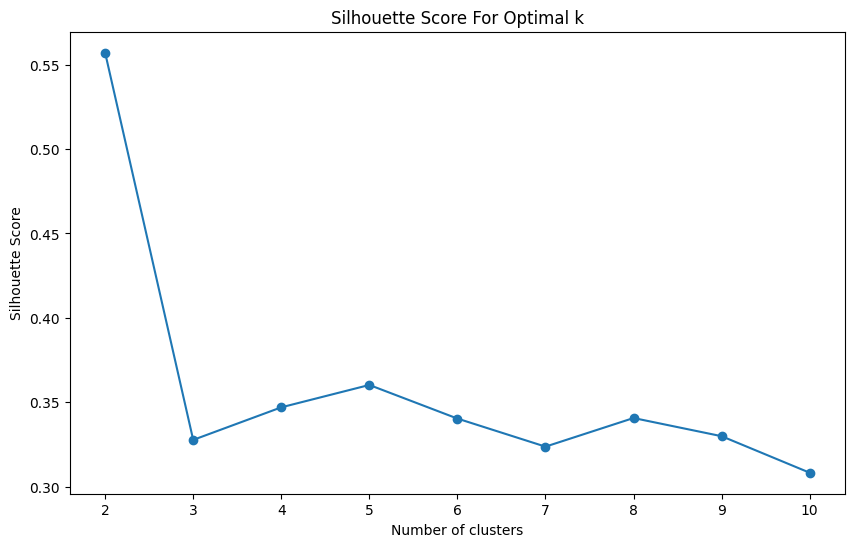

In [38]:
# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
k_range = range(2, 11)  # Silhouette score is not defined for k=1
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_sorted)
    silhouette_avg = silhouette_score(df_sorted, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

In [39]:
# Apply K-Means clustering with the chosen number of clusters 
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]  # Choose the k with the highest silhouette score
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
aggregated_df['CLUSTER'] = kmeans.fit_predict(train_data_preprocessed)

# Display the first few rows to verify
print(aggregated_df.head())

  OUTLET_CODE  SALES_UNITS    UNIT_PTR  FREQUENCY  PRODUCT_CODE_ENCODED  \
0     OL10328     7.607143   60.736317         28             54.000000   
1     OL10329     5.882353   84.794170        187             52.064171   
2     OL10330     5.506306  174.008590        555             47.974775   
3     OL10331     1.808511  165.493230         47             42.702128   
4     OL10332    28.944882    8.872328        127             46.425197   

   CLUSTER  
0        0  
1        1  
2        1  
3        1  
4        0  


In [40]:
aggregated_df.to_csv('outlet_to_cluster_mapping.csv', index=False)

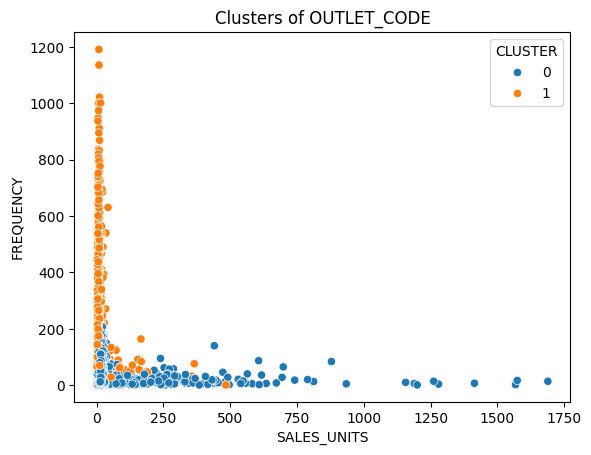

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example visualization Clusters of SALES_UNITS VS SALES_VALUE
sns.scatterplot(x='SALES_UNITS', y='FREQUENCY', hue='CLUSTER', data=aggregated_df)
plt.title('Clusters of OUTLET_CODE')
plt.show()

In [42]:
df_sorted=df_sorted.merge(aggregated_df[['OUTLET_CODE', 'CLUSTER']], on='OUTLET_CODE', how='left')

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from darts import TimeSeries
from darts import RegressionModel
from darts.models import ExponentialSmoothing
from darts.utils.missing_values import fill_missing_values
from sklearn.ensemble import RandomForestRegressor

# Create lagged columns within each group of OUTLET_CODE and PRODUCT_CODE
df_sorted['SALES_UNIT_LAG_1'] = df_sorted.groupby(['OUTLET_CODE', 'PRODUCT_CODE'])['SALES_UNITS'].shift(1)
df_sorted['SALES_UNIT_LAG_2'] = df_sorted.groupby(['OUTLET_CODE', 'PRODUCT_CODE'])['SALES_UNITS'].shift(2)
df_sorted['SALES_UNIT_LAG_3'] = df_sorted.groupby(['OUTLET_CODE', 'PRODUCT_CODE'])['SALES_UNITS'].shift(3)

df_sorted = df_sorted.dropna()

# Convert pandas timeseries dataframe into darts timeseries object

# Define features and target
features = [
    'YEAR', 'MONTH', 'DAY', 'DAYOFWEEK', 'QUARTER',
    'PRODUCT_CODE_ENCODED', 'CATEGORY_ENCODED', 'SUBCATEGORY_ENCODED', 'BRAND_ENCODED',
    'CLUSTER', 'UNIT_PTR'
]
target = 'SALES_UNITS'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Initialize and train the RandomForestRegressor
model = RegressionModel(lags=[-1,-2,-3], lags_features=[0], model = RandomForestRegressor())
model.fit(y_train, lags_features = X_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

ImportError: cannot import name 'RegressionModel' from 'darts' (/opt/conda/lib/python3.9/site-packages/darts/__init__.py)

In [ ]:
train_data.info()

In [ ]:
# import pandas as pd
# from darts import TimeSeries
# from darts.models import LightGBMModel
# from darts.dataprocessing.transformers import Scaler
# from darts.metrics import mape

# # Define features and target
# features = [
#     'YEAR', 'MONTH', 'DAY', 'DAYOFWEEK', 'QUARTER',
#     'PRODUCT_CODE_ENCODED', 'CLUSTER', 'UNIT_PTR'
# ]
# target = 'SALES_UNITS'

# # Create a TimeSeries object for the target variable
# series = TimeSeries.from_group_dataframe(train_data, group_cols = ['OUTLET_CODE','PRODUCT_CODE'], time_col='TRANS_DATE', value_cols=target)

# # Create TimeSeries objects for the features
# feature_series = [TimeSeries.from_group_dataframe(train_data, group_cols = ['OUTLET_CODE','PRODUCT_CODE'], time_col='TRANS_DATE', value_cols=feature) for feature in features]

# # Combine the target series with the feature series
# combined_series = series.stack(*feature_series)

# # Do the above 3 steps for train dataset
# series_test = TimeSeries.from_group_dataframe(test_data, group_cols = ['OUTLET_CODE','PRODUCT_CODE'], time_col='TRANS_DATE', value_cols=target)
# feature_series_test = [TimeSeries.from_group_dataframe(test_data, group_cols = ['OUTLET_CODE','PRODUCT_CODE'], time_col='TRANS_DATE', value_cols=feature) for feature in features]
# combined_series_test = series_test.stack(*feature_series_test)

# # Scale the data
# scaler = Scaler()
# scaled_series = scaler.fit_transform(combined_series)
# scaled_series_test = scaler.fit_transform(combined_series_test)

# # Initialize and train the LightGBMModel
# model = LightGBMModel(lags=3)
# model.fit(scaled_series)

# # Make predictions
# pred = model.predict(len(scaled_series_test))

# # Inverse transform the predictions
# pred = scaler.inverse_transform(pred)

# # Evaluate the model
# print(f"MAPE: {mape(scaled_series_test, pred)}")

# # Plot the results
# series.plot(label='actual')
# pred.plot(label='forecast')

In [ ]:
# import pandas as pd
# from darts import TimeSeries
# from darts.models import LightGBMModel
# from darts.dataprocessing.transformers import Scaler
# from darts.metrics import mape

# # Define features and target
# features = [
#     'YEAR', 'MONTH', 'DAY', 'DAYOFWEEK', 'QUARTER',
#     'PRODUCT_CODE_ENCODED', 'CLUSTER', 'UNIT_PTR'
# ]
# target = 'SALES_UNITS'

# # Create a TimeSeries object for the target variable
# series = TimeSeries.from_group_dataframe(train_data, group_cols = ['OUTLET_CODE','PRODUCT_CODE'], time_col='TRANS_DATE', value_cols=target)

# # Create TimeSeries objects for the features
# feature_series = [TimeSeries.from_group_dataframe(train_data, group_cols = ['OUTLET_CODE','PRODUCT_CODE'], time_col='TRANS_DATE', value_cols=feature) for feature in features]

# # # Combine the target series with the feature series
# # combined_series = series.stack(*feature_series)

# # Do the above 3 steps for train dataset
# series_test = TimeSeries.from_group_dataframe(test_data, group_cols = ['OUTLET_CODE','PRODUCT_CODE'], time_col='TRANS_DATE', value_cols=target)
# feature_series_test = [TimeSeries.from_group_dataframe(test_data, group_cols = ['OUTLET_CODE','PRODUCT_CODE'], time_col='TRANS_DATE', value_cols=feature) for feature in features]

# # combined_series_test = series_test.stack(*feature_series_test)

# # # Scale the data
# # scaler = Scaler()
# # scaled_series = scaler.fit_transform(series)
# # scaled_series_test = scaler.fit_transform(series_test)
# # scaled_feature_series = scaler.fit_transform(feature_series)
# # scaled_feature_series_test = scaler.fit_transform(feature_series_test)

# model = RegressionModel(
#                         lags[-1,-2,-3],
#     lags_features=[0], model=NBEATSModel()
# )

# model.fit(series,feature_series)
# y_pred = model.predict(series_test,feature_series_test)

# # Initialize and train the LightGBMModel
# model = LightGBMModel(lags=3)
# model.fit(scaled_series)

# # Make predictions
# pred = model.predict(len(scaled_series_test))

# # Inverse transform the predictions
# pred = scaler.inverse_transform(pred)

# # Evaluate the model
# print(f"MAPE: {mape(scaled_series_test, pred)}")

# # Plot the results
# series.plot(label='actual')
# pred.plot(label='forecast')